Requirements of the code

In [8]:
# !pip -q install rdkit-pypi==2023.9.5
!pip install rdkit-pypi


   ---------------------------------------- 0.0/20.5 MB ? eta -:--:--
   ---------------------------------------- 0.1/20.5 MB 3.2 MB/s eta 0:00:07
   ---------------------------------------- 0.2/20.5 MB 2.9 MB/s eta 0:00:07
   - -------------------------------------- 0.8/20.5 MB 6.1 MB/s eta 0:00:04
   -- ------------------------------------- 1.2/20.5 MB 7.8 MB/s eta 0:00:03
   --- ------------------------------------ 1.7/20.5 MB 8.2 MB/s eta 0:00:03
   ---- ----------------------------------- 2.3/20.5 MB 8.7 MB/s eta 0:00:03
   ----- ---------------------------------- 2.8/20.5 MB 8.9 MB/s eta 0:00:02
   ----- ---------------------------------- 3.1/20.5 MB 9.3 MB/s eta 0:00:02
   ------- -------------------------------- 3.7/20.5 MB 9.5 MB/s eta 0:00:02
   -------- ------------------------------- 4.3/20.5 MB 9.6 MB/s eta 0:00:02
   --------- ------------------------------ 4.9/20.5 MB 9.8 MB/s eta 0:00:02
   ---------- ----------------------------- 5.4/20.5 MB 10.2 MB/s eta 0:00:02
   --

In [17]:
import pandas as pd
import numpy as np

import ast
from rdkit import Chem, RDLogger
from rdkit.Chem.Draw import MolsToGridImage

In [15]:
df = pd.read_csv(r"dataset\250k_rndm_zinc_drugs_clean_3.csv")
df['smiles'] = df['smiles'].apply(lambda s: s.replace('\n', ''))
df.head()

,smiles,logP,qed,SAS
0,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1,5.05060,0.702012,2.084095
1,C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1,3.11370,0.928975,3.432004
2,N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...,4.96778,0.599682,2.470633
3,CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...,4.00022,0.690944,2.822753
4,N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...,3.60956,0.789027,4.035182


In [18]:
def molecules_from_smile(smiles):
    molecule = Chem.MolFromSmiles(smiles, sanitize=True)

    flag = Chem.SanitizeMol(molecule, catchErrors=True)
    if flag != Chem.SanitizeFlags.SANITIZE_NONE:
        Chem.SanitizeMol(molecule, sanitizeOps=Chem.SanitizeFlags.SANITIZE_ALL ^ flag)

    Chem.AssignStereochemistry(molecule, cleanIt=True, force=True)

    return molecule


SMILES:	COc1ccc([C@H]2C[C@@H](C(F)(F)F)n3nc(C(=O)NC4CCCCC4)cc3N2)cc1OC
logP:	4.6231
qed:	0.661591299118
Molecule:


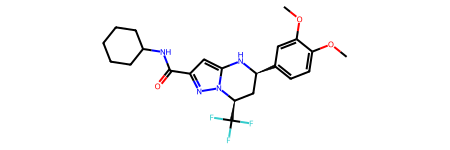

In [21]:
print(f"SMILES:\t{df.smiles[100]}\nlogP:\t{df.logP[100]}\nqed:\t{df.qed[100]}")
molecule = molecules_from_smile(df.smiles[100])
print("Molecule:")
molecule

In [42]:
SMILE_CHARSET = '["C", "B", "F", "I", "H", "O", "N", "S", \
                  "P", "Cl", "Br"]'

bond_mapping = {
    'SINGLE': 0,
    0: Chem.BondType.SINGLE,
    "DOUBLE": 1,
    1: Chem.BondType.DOUBLE,
    'TRIPLE': 2,
    0: Chem.BondType.TRIPLE,
    "AROMATIC": 3,
    1: Chem.BondType.AROMATIC,
}

SMILE_CHARSET = ast.literal_eval(SMILE_CHARSET)
# type(SMILE_CHARSET)

MAX_MOLSIZE = max(df['smiles'].str.len())
SMILE_to_index = dict((c,i) for i, c in enumerate(SMILE_CHARSET))
index_to_SMILE = dict((i,c) for i, c in enumerate(SMILE_CHARSET))
atom_mapping = dict(SMILE_to_index)
atom_mapping.update(index_to_SMILE)

# print(SMILE_to_index)
# print(index_to_SMILE)
# print(atom_mapping)

print("Max molecule size: {}".format(MAX_MOLSIZE))
print("Character set Length: {}".format(len(SMILE_CHARSET)))

Max molecule size: 109
Character set Length: 11


In [66]:
BATCH_SIZE = 32
EPOCHS  = 10

VAE_LR = 5e-4
NUM_ATOMS = 120

ATOM_DIM = len(SMILE_CHARSET)
BOND_DIM = 4 + 1
LATENT_DIM = 435


In [53]:
def smiles_to_graph(smiles):
    # Converts SMILES to molecule object
    molecule = Chem.MolFromSmiles(smiles)

    # Initialize adjacency and feature tensor
    adjacency = np.zeros((BOND_DIM, NUM_ATOMS, NUM_ATOMS), "float32")
    features = np.zeros((NUM_ATOMS, ATOM_DIM), "float32")

    # loop over each atom in molecule
    for atom in molecule.GetAtoms():
        i = atom.GetIdx()
        atom_type = atom_mapping[atom.GetSymbol()]
        features[i] = np.eye(ATOM_DIM)[atom_type]
        # loop over one-hop neighbors
        for neighbor in atom.GetNeighbors():
            j = neighbor.GetIdx()
            bond = molecule.GetBondBetweenAtoms(i, j)
            bond_type_idx = bond_mapping[bond.GetBondType().name]
            adjacency[bond_type_idx, [i, j], [j, i]] = 1

    # Where no bond, add 1 to last channel (indicating "non-bond")
    # Notice: channels-first
    adjacency[-1, np.sum(adjacency, axis=0) == 0] = 1

    # Where no atom, add 1 to last column (indicating "non-atom")
    features[np.where(np.sum(features, axis=1) == 0)[0], -1] = 1

    return adjacency, features

def graph_to_molecule(graph):
    # Unpack graph
    adjacency, features = graph

    # RWMol is a molecule object intended to be edited
    molecule = Chem.RWMol()

    # Remove "no atoms" & atoms with no bonds
    keep_idx = np.where(
        (np.argmax(features, axis=1) != ATOM_DIM - 1)
        & (np.sum(adjacency[:-1], axis=(0, 1)) != 0)
    )[0]
    features = features[keep_idx]
    adjacency = adjacency[:, keep_idx, :][:, :, keep_idx]

    # Add atoms to molecule
    for atom_type_idx in np.argmax(features, axis=1):
        atom = Chem.Atom(atom_mapping[atom_type_idx])
        _ = molecule.AddAtom(atom)

    # Add bonds between atoms in molecule; based on the upper triangles
    # of the [symmetric] adjacency tensor
    (bonds_ij, atoms_i, atoms_j) = np.where(np.triu(adjacency) == 1)
    for (bond_ij, atom_i, atom_j) in zip(bonds_ij, atoms_i, atoms_j):
        if atom_i == atom_j or bond_ij == BOND_DIM - 1:
            continue
        bond_type = bond_mapping[bond_ij]
        molecule.AddBond(int(atom_i), int(atom_j), bond_type)

    # Sanitize the molecule; for more information on sanitization, see
    # https://www.rdkit.org/docs/RDKit_Book.html#molecular-sanitization
    flag = Chem.SanitizeMol(molecule, catchErrors=True)
    # Let's be strict. If sanitization fails, return None
    if flag != Chem.SanitizeFlags.SANITIZE_NONE:
        return None

    return molecule

In [72]:
import torch
from torch.utils.data import Dataset

class DataGenerator(Dataset):
    def __init__(self,data, mapping, max_len, batch_size = 6, shuffle = True):
        self.data = data
        self.indices = self.data.index.tolist()
        self.mapping = mapping
        self.max_len = max_len
        self.batch_size = batch_size
        self.shuffle = shuffle

        # self.on_epoch_end()
    def __len__(self):
        return int(np.ceil(len(self.data)/self.batch_size))
    
    def __getitem__(self, index):
        if (index + 1) * self.batch_size > len(self.indices):
            self.batch_size = len(self.indices) - index * self.batch_size

        index = self.indices[index * self.batch_size : (index + 1) * self.batch_size]

        batch = [self.indices[k] for k in index]
        mol_features, mol_property = self.data_generation(batch)

        return mol_features, mol_property
    def on_epoch_end(self):

        self.index = np.arange(len(self.indices))
        if self.shuffle == True:
            np.random.shuffle(self.index)
        
    def load(self, idx):
        """
        Load molecules adjacency matrix and features matrix from SMILE representation 
        and their respective SAS value.
        """ 
        qed = self.data.loc[idx]['qed']
        adjacency, features = smiles_to_graph(self.data.loc[idx]['smiles'])

        return adjacency, features, qed
    
    def data_generation(self, batch):

        x1 = np.empty((self.batch_size, BOND_DIM, self.max_len, self.max_len))
        x2 = np.empty((self.batch_size, self.max_len, len(self.mapping)))
        x3 = np.empty((self.batch_size,))

        for i, batch_id in enumerate(batch):
            x1[i,], x2[i,], x3[i,] = self.load(batch_id)
            return [x1,x2], x3
        
    




In [57]:
train_df = df.sample(frac=0.75, random_state=42)

test_df = df.drop(train_df.index)
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)


In [59]:
import torch.nn as nn
import torch.nn.functional as F

class RelationalGraphConvLayer(nn.Module):
    def __init__(
            self,
            units = 128,
            activation = 'relu',
            use_bias = False,
            kernel_initializer = 'glorot_uniform',
            bias_initializer = 'zeros',
            kernel_regularizer = None,
            bias_regularizer = None,
            **kwargs
    ):
        super().__init__()

        self.units = units
        self.activation = getattr(F, activation)
        self.use_bias = use_bias
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer
        self.kernel_regularizer = kernel_regularizer
        self.bias_regularizer = bias_regularizer
    
    def reset_parameters(self):
        if self.kernel_initialier == 'glorot_uniform':
            nn.init.xavier_uniform_(self.weight)
        elif self.kernel_initializer == 'glorot_normal':
            nn.init.xavier_normal_(self.weight)
        else:
            raise ValueError("Invalid Kernel initializer")
        
        if self.use_bias:
            nn.init.constant_(self.bias, 0)
    
    def build(self, input_shape):
        bond_dim = input_shape[0][1]
        atom_dim = input_shape[1][2]

        self.weight = nn.Parameter(torch.randn(bond_dim, atom_dim, self.units))

        if self.use_bias:
            self.bias = nn.Parameter(torch.Tensor(bond_dim, 1, self.units))
        self.reset_parameters()

    def forward(self, inputs):
        adjacency, features = inputs

        X = torch.matmul(adjacency, features.unsqueeze(1))

        X = torch.matmul(x, self.weight)
        if self.use_bias:
            x += self.bias
        x_reduced = torch.sum(x, dim=1)
        return self.activation(x_reduced)
    

In [60]:
def get_encoder(gconv_units, latent_dim, adjacency_shape, feature_shape, dense_units, dropout_rate):
    class Encoder(nn.Module):
        def __init__(self, gconv_units, latent_dim, adjacency_shape, feature_shape, dense_units, dropout_rate):
            super(Encoder, self).__init__()

            # Define graph convolutional layers
            self.gconv_layers = nn.ModuleList([RelationalGraphConvLayer(units) for units in gconv_units])

            # Define dense layers
            dense_layers = []
            input_size = gconv_units[-1]  # Input size for the first dense layer
            for units in dense_units:
                dense_layers.append(nn.Linear(input_size, units))
                dense_layers.append(nn.ReLU())
                dense_layers.append(nn.Dropout(dropout_rate))
                input_size = units
            self.dense_layers = nn.Sequential(*dense_layers)

            # Define linear layers for z_mean and log_var
            self.z_mean_layer = nn.Linear(input_size, latent_dim)
            self.log_var_layer = nn.Linear(input_size, latent_dim)

        def forward(self, adjacency, features):
            # Propagate through graph convolutional layers
            features_transformed = features
            for gconv_layer in self.gconv_layers:
                features_transformed = gconv_layer([adjacency, features_transformed])

            # Reduce 2-D representation of molecule to 1-D
            x = torch.mean(features_transformed, dim=1)

            # Propagate through densely connected layers
            x = self.dense_layers(x)

            # Compute z_mean and log_var
            z_mean = self.z_mean_layer(x)
            log_var = self.log_var_layer(x)

            return z_mean, log_var

    # Instantiate the encoder
    encoder = Encoder(gconv_units, latent_dim, adjacency_shape, feature_shape, dense_units, dropout_rate)
    return encoder


In [61]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def get_decoder(dense_units, dropout_rate, latent_dim, adjacency_shape, feature_shape):
    class Decoder(nn.Module):
        def __init__(self, dense_units, dropout_rate, latent_dim, adjacency_shape, feature_shape):
            super(Decoder, self).__init__()

            # Define dense layers
            dense_layers = []
            input_size = latent_dim
            for units in dense_units:
                dense_layers.append(nn.Linear(input_size, units))
                dense_layers.append(nn.Tanh())
                dense_layers.append(nn.Dropout(dropout_rate))
                input_size = units
            self.dense_layers = nn.Sequential(*dense_layers)

            # Define linear layers for adjacency and feature tensors
            self.adjacency_layer = nn.Linear(input_size, torch.prod(torch.tensor(adjacency_shape)))
            self.feature_layer = nn.Linear(input_size, torch.prod(torch.tensor(feature_shape)))

        def forward(self, latent_inputs):
            # Propagate through densely connected layers
            x = self.dense_layers(latent_inputs)

            # Map outputs of previous layer (x) to continuous adjacency tensor
            x_adjacency = self.adjacency_layer(x)
            x_adjacency = x_adjacency.view(-1, *adjacency_shape)
            # Symmetrify tensors in the last two dimensions
            x_adjacency = (x_adjacency + x_adjacency.transpose(1, 2)) / 2
            x_adjacency = F.softmax(x_adjacency, dim=1)

            # Map outputs of previous layer (x) to continuous feature tensor
            x_features = self.feature_layer(x)
            x_features = x_features.view(-1, *feature_shape)
            x_features = F.softmax(x_features, dim=2)

            return x_adjacency, x_features

    # Instantiate the decoder
    decoder = Decoder(dense_units, dropout_rate, latent_dim, adjacency_shape, feature_shape)
    return decoder


In [62]:
class Sampling(nn.Module):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding."""

    def forward(self, z_mean, z_log_var):
        batch = z_log_var.size(0)
        dim = z_log_var.size(1)
        epsilon = torch.randn(batch, dim, device=z_log_var.device)
        return z_mean + torch.exp(0.5 * z_log_var) * epsilon


In [68]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MoleculeGenerator(nn.Module):
    def __init__(self, encoder, decoder, max_len):
        super(MoleculeGenerator, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        # self.property_prediction_layer = nn.Linear(encoder.latent_dim, 1)
        self.max_len = max_len

    def forward(self, mol_features):
        z_mean, z_log_var = self.encoder(mol_features)
        z = self.reparameterize(z_mean, z_log_var)

        reconstruction_adjacency, reconstruction_features = self.decoder(z)

        property_prediction = nn.Linear(z_mean, 1)

        return z_mean, z_log_var, property_prediction, reconstruction_adjacency, reconstruction_features

    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std

    def calculate_loss(self, z_mean, z_log_var, mol_property, property_prediction, graph_real, graph_generated, is_train):
        adjacency_real, features_real = graph_real
        adjacency_generated, features_generated = graph_generated

        adjacency_reconstruction_loss = F.binary_cross_entropy(adjacency_generated, adjacency_real)
        features_reconstruction_loss = F.cross_entropy(features_generated, features_real.argmax(dim=2))

        kl_loss = -0.5 * torch.sum(1 + z_log_var - z_mean.pow(2) - z_log_var.exp(), 1).mean()

        property_prediction_loss = F.binary_cross_entropy_with_logits(property_prediction, mol_property)

        if is_train:
            graph_loss = self.gradient_penalty(graph_real, graph_generated)
        else:
            graph_loss = 0

        return kl_loss + property_prediction_loss + graph_loss + adjacency_reconstruction_loss + features_reconstruction_loss

    def gradient_penalty(self, graph_real, graph_generated):
        adjacency_real, features_real = graph_real
        adjacency_generated, features_generated = graph_generated

        alpha = torch.rand(adjacency_real.size(0), 1, 1, 1)
        alpha = alpha.to(adjacency_real.device)

        adjacency_interp = (adjacency_real * alpha) + (1 - alpha) * adjacency_generated
        features_interp = (features_real * alpha) + (1 - alpha) * features_generated

        adjacency_interp.requires_grad = True
        features_interp.requires_grad = True

        _, _, logits, _, _ = self([adjacency_interp, features_interp])

        grads = torch.autograd.grad(outputs=logits, inputs=[adjacency_interp, features_interp], grad_outputs=torch.ones_like(logits), create_graph=True)

        grads_adjacency_penalty = (1 - grads[0].norm(dim=1)) ** 2
        grads_features_penalty = (1 - grads[1].norm(dim=2)) ** 2

        return torch.mean(torch.mean(grads_adjacency_penalty, dim=(-2, -1)) + torch.mean(grads_features_penalty, dim=(-1)))

    def inference(self, batch_size):
        z = torch.randn(batch_size, self.encoder.latent_dim)
        reconstruction_adjacency, reconstruction_features = self.decoder(z)

        adjacency = reconstruction_adjacency.argmax(dim=1)
        adjacency = F.one_hot(adjacency, num_classes=BOND_DIM)

        adjacency = adjacency - torch.diag(torch.diagonal(adjacency))

        features = reconstruction_features.argmax(dim=2)
        features = F.one_hot(features, num_classes=ATOM_DIM)

        return [
            graph_to_molecule([adjacency[i].detach().numpy(), features[i].detach().numpy()])
            for i in range(batch_size)
        ]


In [73]:
train_loader = DataGenerator(
    data=train_df[:8000],
    mapping = SMILE_to_index, 
    max_len = NUM_ATOMS,
    batch_size=BATCH_SIZE
)

validation_loader = DataGenerator(
    data=test_df[:8000],
    mapping = SMILE_to_index, 
    max_len = NUM_ATOMS,
    batch_size=BATCH_SIZE
)

In [74]:
for i in train_loader:
    print(i)
    break

([array([[[[0., 1., 0., ..., 0., 0., 0.],
         [1., 0., 1., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0.

In [77]:

from torch import optim

# Define the optimizer


# Define the encoder and decoder
encoder = get_encoder(
    gconv_units=[9],
    adjacency_shape=(BOND_DIM, NUM_ATOMS, NUM_ATOMS),
    feature_shape=(NUM_ATOMS, ATOM_DIM),
    latent_dim=LATENT_DIM,
    dense_units=[512],
    dropout_rate=0.0,
    features = 
)
decoder = get_decoder(
    dense_units=[128, 256, 512],
    dropout_rate=0.2,
    latent_dim=LATENT_DIM,
    adjacency_shape=(BOND_DIM, NUM_ATOMS, NUM_ATOMS),
    feature_shape=(NUM_ATOMS, ATOM_DIM)
)

# Define the model
model = MoleculeGenerator(encoder, decoder, MAX_MOLSIZE)
ae_optimizer = optim.Adam(model.parameters(), lr=VAE_LR)
# Define the loss function
criterion = nn.MSELoss()  # or whatever loss function is appropriate for your task

# Train the model
for epoch in range(EPOCHS):
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        ae_optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        ae_optimizer.step()

print('Finished Training')

TypeError: get_encoder.<locals>.Encoder.forward() missing 1 required positional argument: 'features'